# Imports

In [ ]:
%pip install zxcvbn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import os
import json
import pickle
from zxcvbn import zxcvbn
import seaborn as sns
from google.colab import drive
from matplotlib.colors import LinearSegmentedColormap

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper Functions

In [ ]:
def load_and_preprocess_data(file_path, num_samples):
    with open(file_path, 'r', encoding='latin1', errors='ignore') as file:
        lines = file.readlines()

    passwords = [line.strip() for line in lines[:num_samples]]

    return passwords

def test_model(model, tokenizer, test_seq, max_length):
    test_seq_tokenized = tokenizer.texts_to_sequences([test_seq])
    test_seq_padded = pad_sequences(test_seq_tokenized, maxlen=max_length, padding='pre')

    prediction = model.predict(test_seq_padded)

    last_char_output = prediction[0]

    is_probability_distribution = np.all(last_char_output >= 0) and np.isclose(np.sum(last_char_output), 1)

    return last_char_output, is_probability_distribution

def generate_new_password(model, tokenizer, max_length):
    start_index = random.choice(list(tokenizer.word_index.values()))
    sequence = [start_index]

    for _ in range(max_length - 1):
        padded_sequence = pad_sequences([sequence], maxlen=max_length, padding='pre')
        predictions = model.predict(padded_sequence, verbose=0)[0]
        next_char_index = np.random.choice(len(predictions), p=predictions)
        if next_char_index == 0:
            break
        sequence.append(next_char_index)

    generated_password = ''.join(tokenizer.sequences_to_texts([sequence])[0])
    print('generated a password!')
    return generated_password.strip()


def calculate_password_probability(model, tokenizer, target_password, max_length):
  sequence = []
  probability = 1.0

  for char in target_password:
    padded_sequence = pad_sequences([sequence], maxlen=max_length, padding='pre')
    predictions = model.predict(padded_sequence, verbose=0)[0]

    char_index = tokenizer.word_index.get(char, 0)
    probability *= predictions[char_index]

    sequence.append(char_index)
    if len(sequence) > max_length:
      sequence = sequence[1:]
  print('returning probability')
  return probability

def process_batch(model, tokenizer, passwords_batch, max_length):
    batch_probabilities = {}
    for pwd in passwords_batch:
      pwd_probability = calculate_password_probability(model, tokenizer, pwd, max_length)
      batch_probabilities[pwd] = pwd_probability
    return batch_probabilities

def calculate_probabilities_in_batches(model, tokenizer, passwords, max_length, batch_size=1000):
    total_num_passwords = len(passwords)
    all_probabilities = {}

    for start_index in range(0, total_num_passwords, batch_size):
      end_index = min(start_index + batch_size, total_num_passwords)
      passwords_batch = passwords[start_index:end_index]
      batch_probabilities = process_batch(model, tokenizer, passwords_batch, max_length)
      all_probabilities.update(batch_probabilities)
      print(f'Processed {end_index}/{total_num_passwords} passwords')

    return all_probabilities

def monte_carlo_to_determine_guess_number(target_password, passwords_probabilities):
    target_probability = passwords_probabilities.get(target_password)

    if target_probability is None:
        target_probability = calculate_password_probability(model, tokenizer, target_password, max_sequence_len)

    num_higher_prob = sum(1 for _, prob in passwords_probabilities.items() if prob > target_probability)

    guess_number = num_higher_prob + 1

    return guess_number

def test_password_strength_via_monte_carlo_guess_number(target_password, passwords_probabilities):
  estimated_guess_number = monte_carlo_to_determine_guess_number(target_password, passwords_probabilities)
  strength_string, strength_number = assess_password_strength_with_guess_number(estimated_guess_number)
  return strength_string, strength_number, estimated_guess_number

def test_password_strength_via_zxcvbn(target_password):
  zxcvbn_result = zxcvbn(target_password)
  zxcvbn_strength_number = zxcvbn_result['score']
  zxcvbn_guess_number = zxcvbn_result['guesses']

  zxcvbn_string = ''
  if zxcvbn_strength_number == 0:
    zxcvbn_string = 'Very Weak'
  elif zxcvbn_strength_number == 1:
    zxcvbn_string = 'Weak'
  elif zxcvbn_strength_number == 2:
    zxcvbn_string = 'Average'
  elif zxcvbn_strength_number == 3:
    zxcvbn_string = 'Strong'
  elif zxcvbn_strength_number == 4:
    zxcvbn_string = 'Very Strong'

  return zxcvbn_string, zxcvbn_strength_number, zxcvbn_guess_number

def test_all_password_strengths(target_passwords_list, passwords_probabilities):
  pswd_to_nn_strength = {}
  pswd_to_zxcvbn_strength = {}
  for target_password in target_passwords_list:
    nn_strength_string, nn_strength_number, nn_guess_number = test_password_strength_via_monte_carlo_guess_number(target_password, passwords_probabilities)
    zxcvbn_strength_string, zxcvbn_strength_number, zxcvbn_guess_number = test_password_strength_via_zxcvbn(target_password)
    pswd_to_nn_strength[target_password] = [nn_strength_string, nn_strength_number, nn_guess_number]
    pswd_to_zxcvbn_strength[target_password] = [zxcvbn_strength_string, zxcvbn_strength_number, zxcvbn_guess_number]

  return pswd_to_nn_strength, pswd_to_zxcvbn_strength

def assess_password_strength_with_guess_number(guess_number):
    if guess_number < 1250:
        return 'Very Weak', 0
    elif guess_number < 2500:
        return 'Weak', 1
    elif guess_number < 3750:
        return 'Average', 2
    elif guess_number < 5000:
        return 'Strong', 3
    else:
        return 'Very Strong', 4

    # if guess_number < 610:
    #     return 'Very Weak', 0
    # elif guess_number < 2048:
    #     return 'Weak', 1
    # elif guess_number < 3407:
    #     return 'Average', 2
    # elif guess_number < 5000:
    #     return 'Strong', 3
    # else:
    #     return 'Very Strong', 4

# 25% of passwords have a guess number estimate less than 610.0
# 50% of passwords have a guess number estimate less than 2048.0
# 75% of passwords have a guess number estimate less than 3407.0
# 99% of passwords have a guess number estimate less than 4004.0


# Preprocessing Data

In [ ]:
# rockyou dataset link: https://www.kaggle.com/datasets/wjburns/common-password-list-rockyoutxt/

path_to_rockyou_passwords_file = '/content/drive/Shareddrives/439 final project/rockyou.txt'
passwords = load_and_preprocess_data(path_to_rockyou_passwords_file, 30000)

In [ ]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(passwords)
sequences = tokenizer.texts_to_sequences(passwords)
max_length = max([len(x) for x in sequences])

# print(max_length)
# print(passwords[0])
# print(passwords[1])
# print(sequences)

In [ ]:
# Pad sequences to ensure consistent input size
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')
for i in range(3):
  print(sequences_padded[i])

[ 9 15 25 30 29 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 9 15 25 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 9 15 25 30 29 31 32 23 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
vocab_size

69

# Training the Neural Network

In [ ]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 39, 50)            3450      
                                                                 
 lstm_4 (LSTM)               (None, 39, 128)           91648     
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 69)                8901      
                                                                 
Total params: 235,583
Trainable params: 235,583
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_sequences = []
next_chars = []

for seq in sequences_padded:
    for i in range(1, len(seq)):
        input_sequences.append(seq[:i])
        next_chars.append(seq[i])

# Pad each sequence to the same length: the length of the longest sequence
max_sequence_len = max([len(x) for x in input_sequences]) + 1 # to match max_length above
input_sequences_padded = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
X = np.array(input_sequences_padded)
y = np.array(next_chars)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)

912000

In [ ]:
model_save_path = '/content/drive/Shareddrives/439 final project/my_nn_password_strength_assessor_model.h5'
history_save_path = '/content/drive/Shareddrives/439 final project/model_history.pkl'

# Check if the model file exists
if os.path.exists(model_save_path):
    model = load_model(model_save_path)
    if os.path.exists(history_save_path):
      with open(history_save_path, 'rb') as file:
        history = pickle.load(file)
    else:
      history = None
else:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    history = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_data=(X_val, y_val))

    model.save(model_save_path)
    with open(history_save_path, 'wb') as file:
      pickle.dump(history.history, file)


In [ ]:
test_sequence = 'flipper'
output, is_prob_dist = test_model(model, tokenizer, test_sequence, max_sequence_len)

print(f'Output: {output}')
print(f'len(Output): {len(output)}')
print(f'Is a probability distribution: {is_prob_dist}')


1/1 [==============================] - 3s 3s/step
Output: [3.00433666e-01 1.08922180e-02 1.28464419e-02 1.04905013e-02
 7.37360492e-03 2.35752650e-02 5.33658732e-03 4.00055572e-02
 2.04544157e-01 1.19120628e-01 3.69347781e-02 1.43824276e-02
 7.46925827e-03 1.34941125e-02 8.35589599e-03 3.78026292e-02
 4.10490809e-03 2.86785048e-02 5.46848122e-03 1.69880483e-02
 9.19393823e-03 8.18945374e-03 7.92813394e-03 6.54542539e-03
 3.96727910e-03 7.29365880e-03 6.38647994e-04 1.07337059e-02
 1.85831112e-03 4.63203713e-03 2.89752986e-03 3.72242741e-03
 1.03237201e-02 8.09251156e-04 6.10852800e-03 1.07084052e-03
 2.71222641e-04 3.92253976e-03 9.56473959e-05 4.14865790e-04
 5.05038770e-04 2.62384739e-04 5.93946534e-05 4.40396116e-06
 3.57119643e-05 3.51025192e-05 2.42868755e-05 5.69187068e-06
 8.63966670e-06 4.51238748e-07 5.18848128e-06 2.54055635e-06
 6.73440518e-05 3.26447298e-06 9.81787798e-06 1.17384989e-05
 8.99831412e-06 6.77143225e-06 5.05304888e-06 5.25645419e-06
 1.35731369e-07 2.29261104e

In [ ]:
if history:
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


# Monte Carlo Method for Estimating Guess Numbers

In [ ]:
generated_passwords_file_path = '/content/drive/Shareddrives/439 final project/generated_passwords_list.txt'

if not os.path.exists(generated_passwords_file_path):
  num_passwords_to_generate = 1000
  generated_passwords_list = [generate_new_password(model, tokenizer, max_sequence_len) for _ in range(num_passwords_to_generate)]

  print(generated_passwords_list[:10])

  with open(generated_passwords_file_path, 'w') as file:
    for password in generated_passwords_list:
      file.write('%s\n' % password)

    print('Generated passwords have been saved to generated_passwords_list.txt')
else:
    with open(generated_passwords_file_path, 'r') as file:
      generated_passwords_list = file.read().splitlines()

    print('Loaded generated passwords from generated_passwords_list.txt')


Loaded generated passwords from generated_passwords_list.txt


In [ ]:
probabilities_file_path = '/content/drive/Shareddrives/439 final project/passwords_probabilities.pkl'
if os.path.exists(probabilities_file_path):
  with open(probabilities_file_path, 'rb') as file:
    passwords_probabilities = pickle.load(file)
else:
  sample_passwords = passwords[:4000] + generated_passwords_list
  passwords_probabilities = calculate_probabilities_in_batches(model, tokenizer, sample_passwords, max_sequence_len)
  with open(probabilities_file_path, 'wb') as file:
    pickle.dump(passwords_probabilities, file)

In [ ]:
target_password = "examplepassword"
estimated_guess_number = monte_carlo_to_determine_guess_number(target_password, passwords_probabilities)
print("Estimated Guess Number for target password:", estimated_guess_number)

target_password = "123456"
estimated_guess_number = monte_carlo_to_determine_guess_number(target_password, passwords_probabilities)
print("Estimated Guess Number for target password:", estimated_guess_number)

target_password = "password"
estimated_guess_number = monte_carlo_to_determine_guess_number(target_password, passwords_probabilities)
print("Estimated Guess Number for target password:", estimated_guess_number)

target_password = "areallyreallystrongpa$$w)rD"
estimated_guess_number = monte_carlo_to_determine_guess_number(target_password, passwords_probabilities)
print("Estimated Guess Number for target password:", estimated_guess_number)

returning probability
Estimated Guess Number for target password: 4004
Estimated Guess Number for target password: 29
Estimated Guess Number for target password: 1691
returning probability
Estimated Guess Number for target password: 4915


# Results / Conclusion

In [ ]:
path_to_phpbb_passwords_file = '/content/drive/Shareddrives/439 final project/phpbb.txt'
phpbb_passwords = load_and_preprocess_data(path_to_phpbb_passwords_file, 500)

path_to_faith_passwords_file = '/content/drive/Shareddrives/439 final project/faithwriters.txt'
faith_passwords = load_and_preprocess_data(path_to_faith_passwords_file, 500)

test_passwords = phpbb_passwords + faith_passwords + ['vanillacakepop', 'ohmanohmanohman', 'peterpiperporter']

In [ ]:
nn_strength, zxcvbn_strength = test_all_password_strengths(test_passwords, passwords_probabilities)

In [ ]:
guess_estimates = [value[2] for value in nn_strength.values()]

sorted_estimates = sorted(guess_estimates)

x = np.percentile(sorted_estimates, 25)
y = np.percentile(sorted_estimates, 50)
z = np.percentile(sorted_estimates, 75)
q = np.percentile(sorted_estimates, 99)

print(f"25% of passwords have a guess number estimate less than {x}")
print(f"50% of passwords have a guess number estimate less than {y}")
print(f"75% of passwords have a guess number estimate less than {z}")
print(f"99% of passwords have a guess number estimate less than {q}")

25% of passwords have a guess number estimate less than 611.75
50% of passwords have a guess number estimate less than 2058.5
75% of passwords have a guess number estimate less than 3419.75
99% of passwords have a guess number estimate less than 4008.11


In [ ]:
count_scores_diff_by_0 = 0
count_scores_diff_by_1 = 0
count_scores_diff_by_2 = 0
count_scores_diff_by_3 = 0
count_scores_diff_by_4 = 0
count_scores_nn_gt_zxcvbn = 0
count_scores_nn_lt_zxcvbn = 0
count_scores_nn_eq_zxcvbn = 0

for pswd in test_passwords:
  nn_result = nn_strength[pswd]
  zxcvbn_result = zxcvbn_strength[pswd]
  nn_strength_string = nn_result[0]
  nn_strength_number = nn_result[1]
  nn_guess_number = nn_result[2]
  zxcvbn_strength_string = zxcvbn_result[0]
  zxcvbn_strength_number = zxcvbn_result[1]
  zxcvbn_guess_number = zxcvbn_result[2]

  score_difference = abs(zxcvbn_strength_number - nn_strength_number)

  if score_difference == 0:
    count_scores_diff_by_0 += 1
  elif score_difference == 1:
    count_scores_diff_by_1 += 1
  elif score_difference == 2:
    count_scores_diff_by_2 += 1
  elif score_difference == 3:
    count_scores_diff_by_3 += 1
  elif score_difference == 4:
    count_scores_diff_by_4 += 1

  if nn_strength_number > zxcvbn_strength_number:
    count_scores_nn_gt_zxcvbn += 1
  elif nn_strength_number < zxcvbn_strength_number:
    count_scores_nn_lt_zxcvbn += 1
  else:
    count_scores_nn_eq_zxcvbn += 1

  if pswd == 'ohmanohmanohman':
    print(f'PASSWORD: {pswd}')
    print(f'NN Strength: {nn_strength_string} - {nn_strength_number}')
    print(f'ZXCVBN: {zxcvbn_strength_string} - {zxcvbn_strength_number}')

print(f'\nScores differed by 0: {count_scores_diff_by_0}')
print(f'Scores differed by 1: {count_scores_diff_by_1}')
print(f'Scores differed by 2: {count_scores_diff_by_2}')
print(f'Scores differed by 3: {count_scores_diff_by_3}')
print(f'Scores differed by 4: {count_scores_diff_by_4}')
print(f'NN gave stronger score than ZXCVBN: {count_scores_nn_gt_zxcvbn}')
print(f'NN gave weaker score than ZXCVBN: {count_scores_nn_lt_zxcvbn}')
print(f'NN gave equal score than ZXCVBN: {count_scores_nn_eq_zxcvbn}')

PASSWORD: ohmanohmanohman
NN Strength: Strong - 3
ZXCVBN: Weak - 1

Scores differed by 0: 313
Scores differed by 1: 504
Scores differed by 2: 158
Scores differed by 3: 28
Scores differed by 4: 0
NN gave stronger score than ZXCVBN: 481
NN gave weaker score than ZXCVBN: 209
NN gave equal score than ZXCVBN: 313


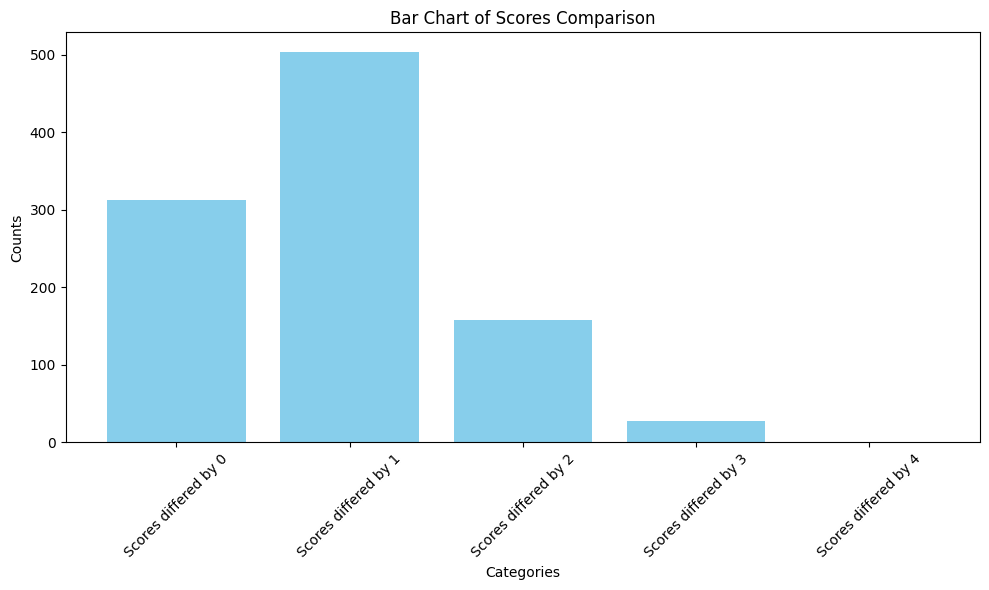

In [ ]:
categories = ['Scores differed by 0', 'Scores differed by 1', 'Scores differed by 2', 'Scores differed by 3', 'Scores differed by 4']
counts = [count_scores_diff_by_0, count_scores_diff_by_1, count_scores_diff_by_2, count_scores_diff_by_3, count_scores_diff_by_4]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Bar Chart of Scores Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

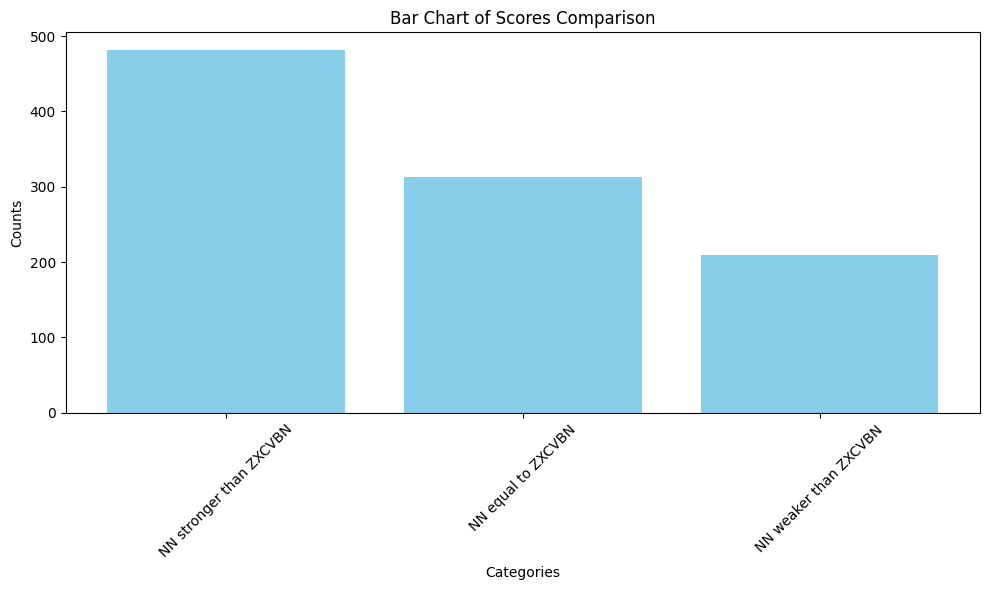

In [ ]:
categories = ['NN stronger than ZXCVBN', 'NN equal to ZXCVBN', 'NN weaker than ZXCVBN']
counts = [count_scores_nn_gt_zxcvbn, count_scores_nn_eq_zxcvbn, count_scores_nn_lt_zxcvbn]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Bar Chart of Scores Comparison')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()